We often need to cluster nodes together. 
There are two main cases: 1. clustering of the graph itself, and 2. clustering
of data points based on some property. Such a case is for instance needed when 
clustering neurons based on the similarity of their input-output properties.

This notebooks aims at comparing implemented methods.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import specific_neurons.mdn_helper as mdn_helper
import specific_neurons.motor_neurons_helper as mns_helper

# I. Clustering of the graph itself

# II. Clustering of data points based on some property
Example for the beanchmarking: cluster motor neurons in T3 based on their cosine
similarity in terms of inputs.

In [4]:
full_VNC = mdn_helper.get_vnc_split_MDNs_by_neuropil(
    not_connected=mdn_helper.get_mdn_bodyids()
)
VNC = full_VNC.get_connections_with_only_traced_neurons()
motor_neurons = mns_helper.get_leg_motor_neurons(VNC, leg="h", side="RHS")

Loaded VNC Connections object with MDNs split by neuropil.
Attribute status:string not found in the graph. Adding it.
Attribute class:string not found in the graph. Adding it.


# Test

### A. hierarchical with matrix traverse

In [5]:
# Restricting
cmatrix_1 = VNC.get_cmatrix(type_="unnorm")
premotor_neurons = cmatrix_1.list_upstream_neurons(motor_neurons)
nodes = list(set(motor_neurons).union(premotor_neurons))
cmatrix_1.restrict_nodes(nodes)

# Clustering
(
    clustered_cmatrix_1, # clustered similarity matrix as cmatrix object
    uid_clusters_1, # list of lists of uids in each cluster
    index_clusters_1, # list of lists of indices in each cluster matching the clustered cmatrix
) = cmatrix_1.detect_clusters(
    distance="cosine_in",
    method="hierarchical",
    cutoff=0.5,
    cluster_size_cutoff=2,
    cluster_data_type="uid",
    cluster_on_subset = motor_neurons,
)

/home/hurtak/miniconda3/envs/vnc/lib/python3.12/site-packages/numpy/matrixlib/defmatrix.py:446: RuntimeWarning: Mean of empty slice.
  return N.ndarray.mean(self, axis, dtype, out, keepdims=True)._collapse(axis)
/home/hurtak/miniconda3/envs/vnc/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [6]:
def show_clustering(cmatrix, clustered_cmatrix, uid_clusters,index_clusters):

    _, axs = plt.subplots(2, 1, figsize=(10, 10))

    # Left: visualise similarity data
    clustered_mat = clustered_cmatrix.get_matrix().todense()
    # create a matrix of zeros
    mat = np.zeros((clustered_mat.shape[0], clustered_mat.shape[1]))
    # draw the boundaries between clusters
    for cluster in index_clusters:
        mat[cluster[0] : cluster[-1] + 1, cluster[0] : cluster[-1] + 1] = 1
    _ = clustered_cmatrix.imshow(savefig=False, ax=axs[0], title="Clustered similarity matrix")
    #axs[0].imshow(mat, cmap="binary", alpha=0.1)

    # Right: visualise the initial adjacency matrix where the rows are the premotor
    # neurons and the columns are the motor neurons, and the premotor neurons are
    # ordered according to the clusters, with vertical lines separating the clusters
    sorted_motor_neurons = [n for cluster in uid_clusters for n in cluster]
    sorted_motor_neurons.extend(
        list(set(motor_neurons).difference(set(sorted_motor_neurons)))
        )
    # sort premotor neurons: find the premotor neurons that project to at least 
    # x% of the motor neurons in a given cluster, and sort them according to the
    # clusters. Append the others at the end.
    sorted_premotor_neurons = []
    for cluster in uid_clusters:
        to_add = cmatrix.list_neurons_upstream_set(cluster, ratio=0.5)
        sorted_premotor_neurons.extend(
            list(set(to_add).difference(set(sorted_premotor_neurons))) # avoid duplicates
            )
    sorted_premotor_neurons.extend(
        list(set(premotor_neurons).difference(set(sorted_premotor_neurons))) # complete
        )

    # restrict the adjacency matrix to the premotor neurons and the motor neurons
    cmatrix.restrict_from_to(
        sorted_premotor_neurons,
        sorted_motor_neurons,
        input_type="uid",
        keep_initial_order=False,
        )
    _ = cmatrix.spy(savefig=False, ax=axs[1], title="Adjacency matrix")
    sum_c = 0
    for i in range(0, len(uid_clusters)):
        sum_c += len(index_clusters[i])
        axs[1].axvline(sum_c, color="black")
    plt.tight_layout()

    plt.show()

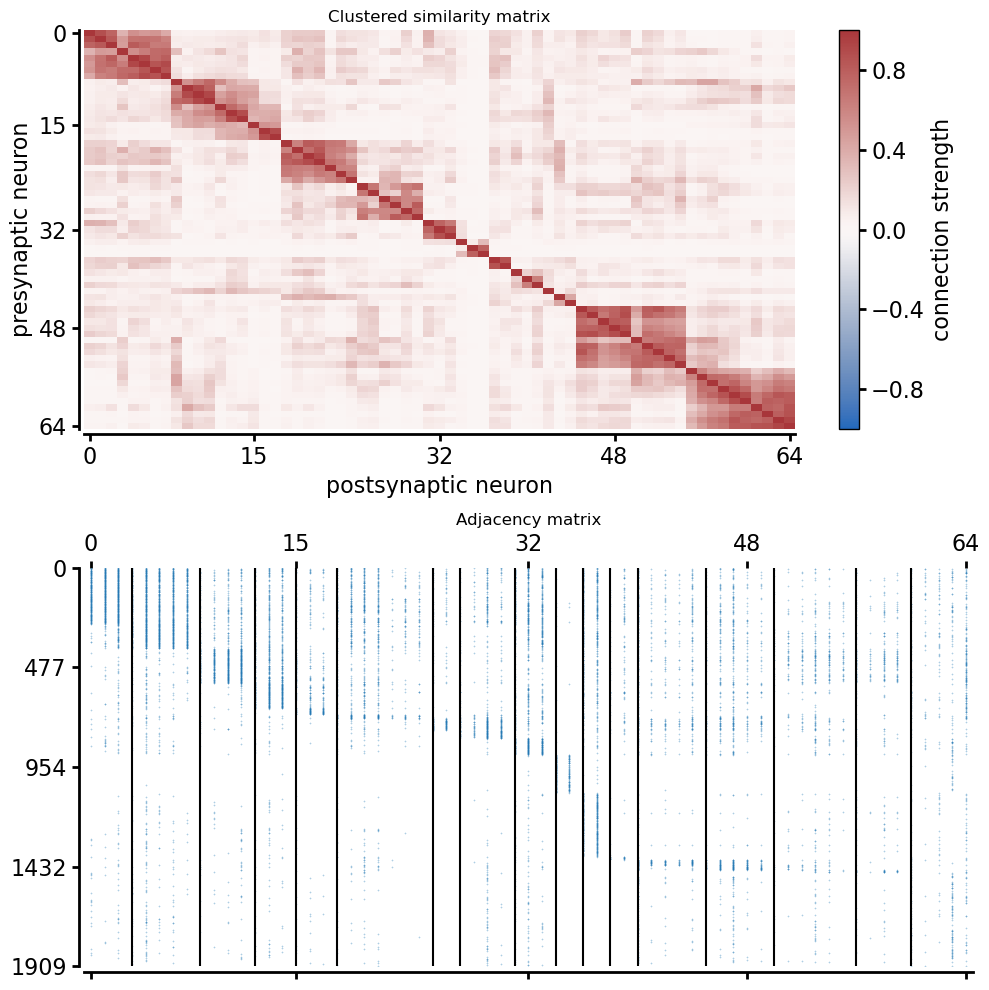

In [7]:
show_clustering(cmatrix_1, clustered_cmatrix_1, uid_clusters_1,index_clusters_1)

### B. Hierarchical with native clustering

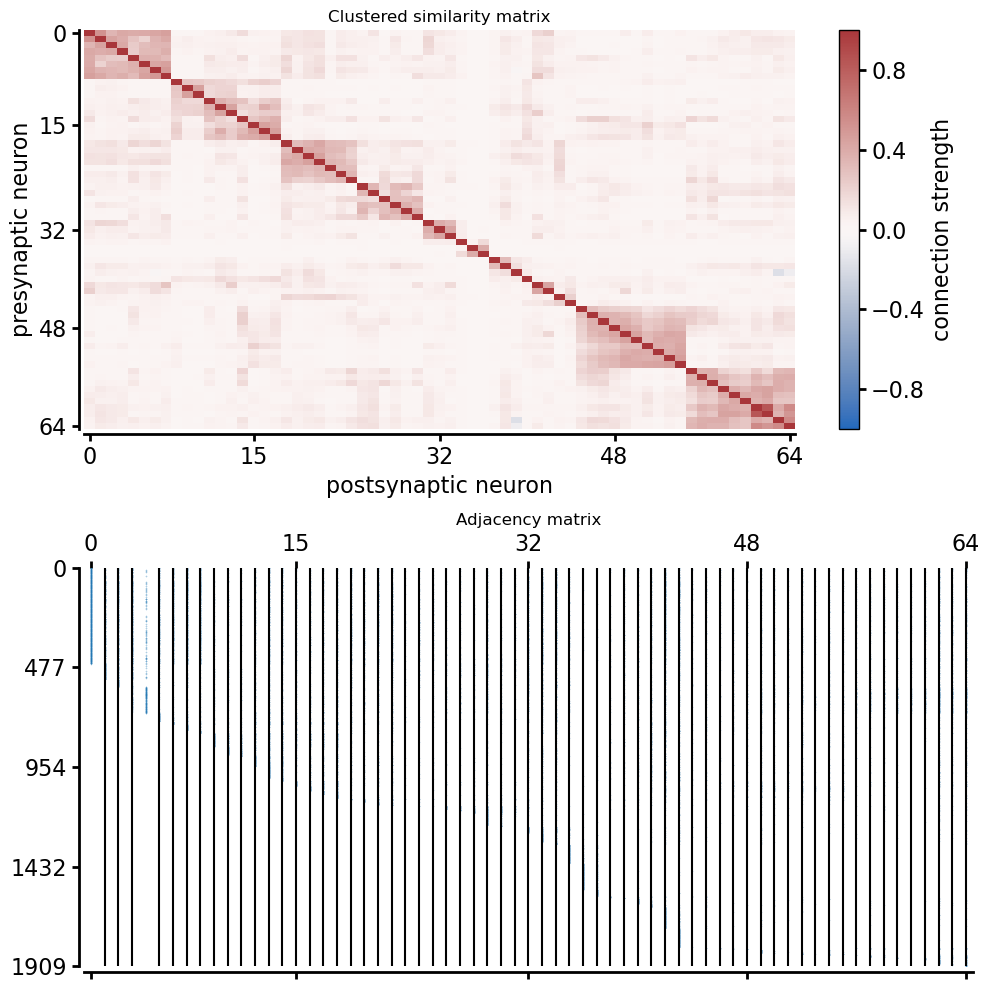

In [8]:
# Restricting
cmatrix_2 = VNC.get_cmatrix(type_="unnorm")
premotor_neurons = cmatrix_2.list_upstream_neurons(motor_neurons)
nodes = list(set(motor_neurons).union(premotor_neurons))
cmatrix_2.restrict_nodes(nodes)

# Clustering
(
    clustered_cmatrix_2, # clustered similarity matrix as cmatrix object
    uid_clusters_2, # list of lists of uids in each cluster
    index_clusters_2, # list of lists of indices in each cluster matching the clustered cmatrix
) = cmatrix_2.detect_clusters(
    distance="cosine",
    method="hierarchical_linkage",
    cutoff=0.5,
    cluster_size_cutoff=2,
    cluster_data_type="uid",
    cluster_on_subset = motor_neurons,
)

show_clustering(cmatrix_2, clustered_cmatrix_2, uid_clusters_2,index_clusters_2)